<img src="image/hft_logo.jpg"
     alt="Hft Logo"
     align="right" 
     width="150" 
     height="150" />
# Mathematik Master Seminar
## Zeitreihenprognose mit Long short-term memory

---
### Philipp Dörich & Tim Oliver Walter
### 13. Dezember 2021

---

## Agenda
1. [Importing Data](#Importing_Data)
2. [Data Preparation and Manipulation](#Data_Preparation_Manipulation)
3. [Exploratory Data Analysis](#EDA)
4. [Create Model](#Create_Model)
5. [Forecasting](#Forecasting)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use("fivethirtyeight")

## Importing Data <a name="Importing_Data"></a>

The data are the time series of the concentration of Particulate Matter 2.5 in the air of Milan.

The data have been sampled using a laser-scattering PM2.5 sensor.

The sampling frequency varies from 1/15min to 1/1h. The dataset contains hourly means.

Data have been sampled in Milan, at 45.4582861 North 9.1675597 East.

Data have been sampled from 2020-07-24 to 2020-09-20.

In [2]:
filepath = "data/aq_milan_summer_2020.csv"
df = pd.read_csv(filepath)
df.head()

,local_datetime,pm2p5
0,2020-07-24 18:00:00,11.67
1,2020-07-24 19:00:00,9.25
2,2020-07-24 20:00:00,6.29
3,2020-07-24 21:00:00,5.50
4,2020-07-24 22:00:00,9.50


In [3]:
print("Null values local_datetime:", df.isnull().sum()[0])
print("Null values pm2p5:", df.isnull().sum()[1])

Null values local_datetime: 0
Null values pm2p5: 0


In [4]:
stats = df.describe().transpose()
stats = stats.rename({"count":"rows"},axis=1)
stats

,rows,mean,std,min,25%,50%,75%,max
pm2p5,1398.0,12.668863,8.568262,1.0,6.0,10.225,17.9375,52.0


## Data Preparation and Manipulation <a name="Data_Preparation_Manipulation"></a>

In [5]:
# Als Zeitreihe darstellen
df = df.rename({
    "local_datetime":"ds",
    "pm2p5":"y"},
    axis=1)
df["ds"] = pd.to_datetime(df["ds"])
df = df.set_index("ds")
#df= df.asfreq(freq="H")
df.head()

,y
ds,
2020-07-24 18:00:00,11.67
2020-07-24 19:00:00,9.25
2020-07-24 20:00:00,6.29
2020-07-24 21:00:00,5.50
2020-07-24 22:00:00,9.50


## Exploratory Data Analysis <a name="EDA"></a>

Eine Zeitreihe $y_t$ besteht aus endlich vielen, zeitlich angeordneten Messwerten:

$x_{t_1}, x_{t_2}, \ldots, x_{t_T}$ &nbsp;&nbsp; mit &nbsp;&nbsp; $x_{t_k} \in \mathbb{R}^n$ &nbsp;&nbsp; und &nbsp;&nbsp; $k = 1, 2, \ldots, T$.

Wobei gilt: &nbsp;&nbsp; $t_1 < t_2 < \ldots < t_T$.

Man nennt eine Zeitreihe **skalar** oder **univariat**, wenn $n = 1$ gilt, also zu jedem Zeitpunkt nur eine Beobachtung vorliegt. 

Liegen zu jedem Zeitpunkt $n > 1$ Beobachtungen vor, spricht man von **multivariaten** Zeitreihen. 

***TODO:*** Beispiel multivariate Zeitreihe!


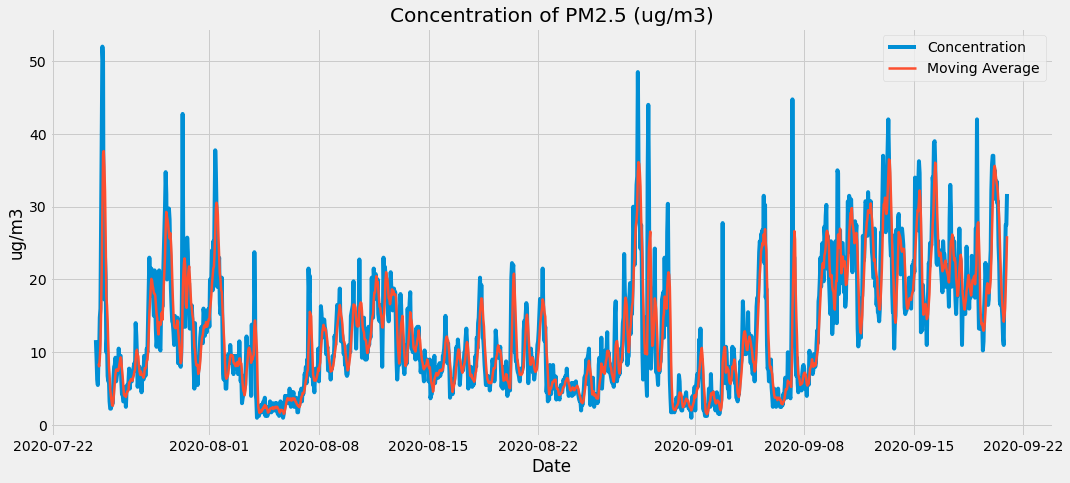

In [6]:
roll_mean = df.y.rolling(5).mean()
roll_std = df.y.rolling(5).std()

plt.figure(figsize=(16, 7))
plt.plot(df, label="Concentration")
plt.plot(roll_mean ,label="Moving Average",linewidth=2.5)
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

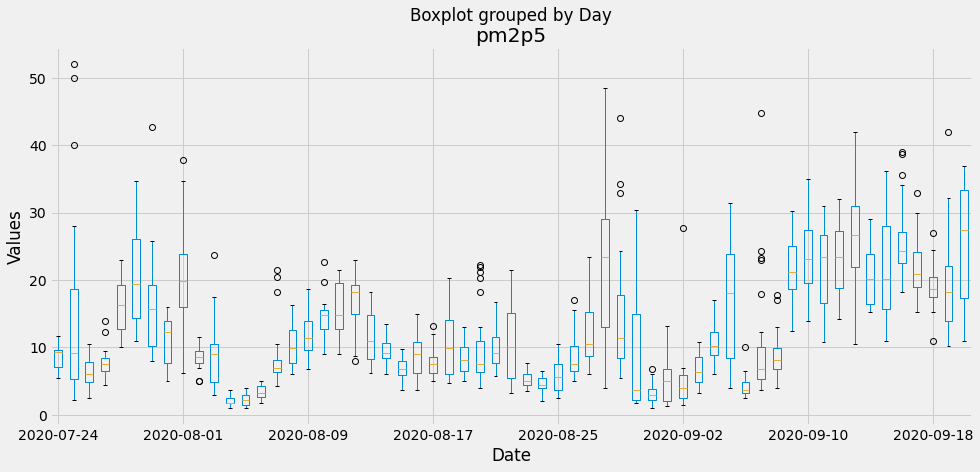

In [7]:
boxplot_df = df.copy()
boxplot_df["Day"] = boxplot_df.index.dayofyear
fig, ax = plt.subplots(figsize=(16, 7))
boxplot_df.boxplot(by ='Day', column =['y'], ax = ax)
ax.set_xticks(ax.get_xticks()[::8])
ax.set_xticklabels(boxplot_df.Day[::192].index.date)
plt.title("pm2p5")
plt.ylabel("Values")
plt.xlabel("Date")
plt.show()

Was ist ein Histogramm (mathematisch)

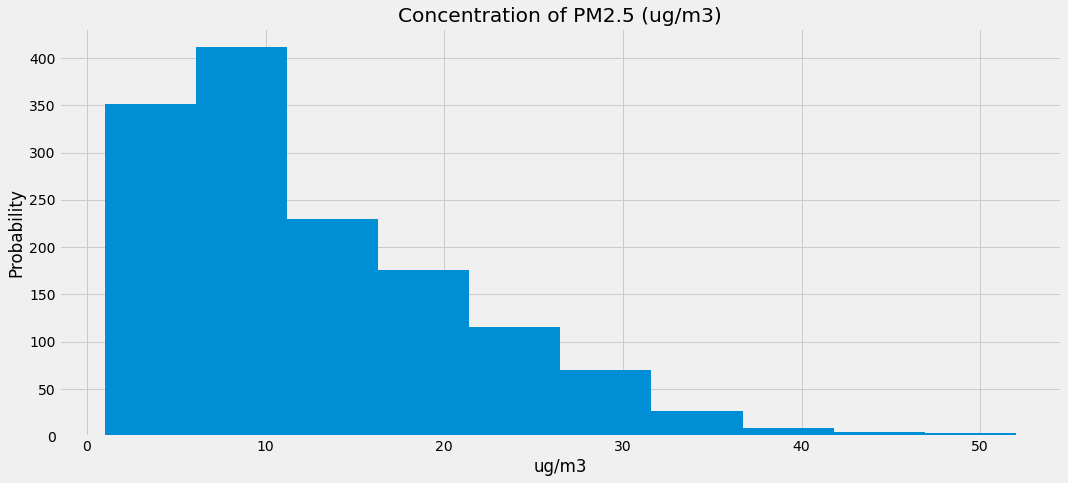

In [8]:
plt.figure(figsize=(16, 7))
plt.hist(df)
plt.xlabel("ug/m3")
plt.ylabel("Probability")
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

Eine Zeitreihe $y_t$ lässt sich analog zu unserer obigen Definition, auf zwei Arten beschreiben:

Additiv: &nbsp;&nbsp; $y_t = S_t + T_t + R_t$

Multiplikativ: &nbsp;&nbsp; $y_t = S_t \cdot T_t \cdot R_t$

Dies ist von Vorteil, da in Zeitreihen oft mehrere Muster enthalten sind. Um diese Muster darstellen zu können wird die Zeitreihe in verschiedene Komponenten aufgeteilt. Die Komponenten sind wie folgt definiert:

$S_t :=$ Sesonalität

$T_t :=$ Trend

$R_t :=$ Rauschen

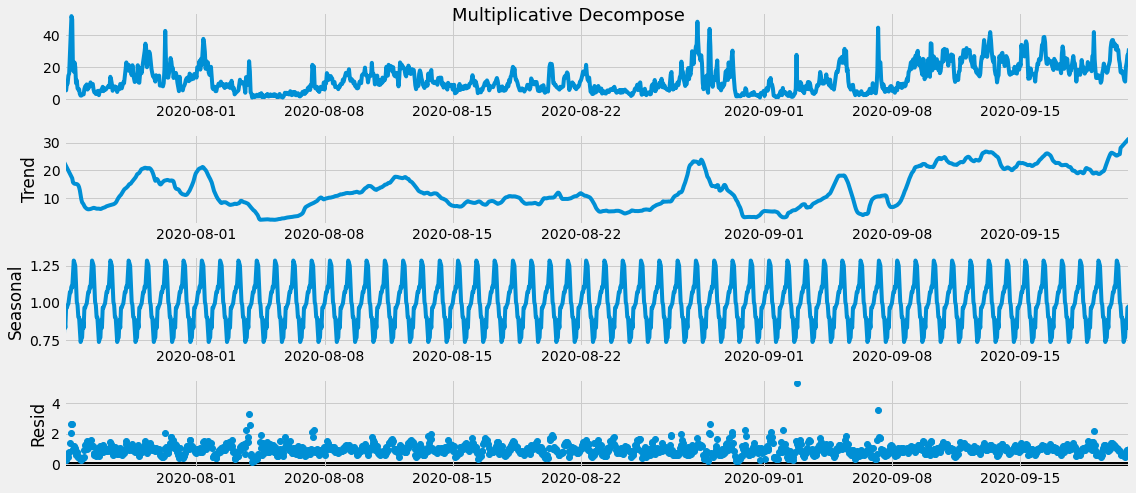

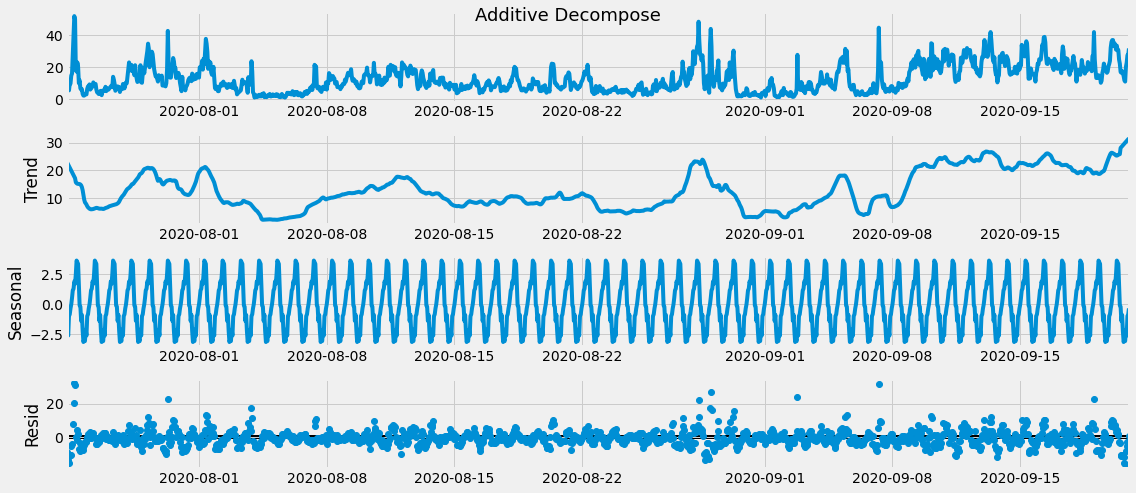

In [9]:
decompose_result_add = seasonal_decompose(df, model="additive", extrapolate_trend="freq")
decompose_result_mul = seasonal_decompose(df, model="multiplicative", extrapolate_trend="freq")

plt.rcParams.update({'figure.figsize': (16, 7)})
decompose_result_mul.plot().suptitle("Multiplicative Decompose", fontsize=18)
decompose_result_add.plot().suptitle("Additive Decompose", fontsize=18)
plt.show()

$\Rightarrow$ The additive decomposition, looks quite random. So ideally, additive decomposition should be preferred for this particular series.

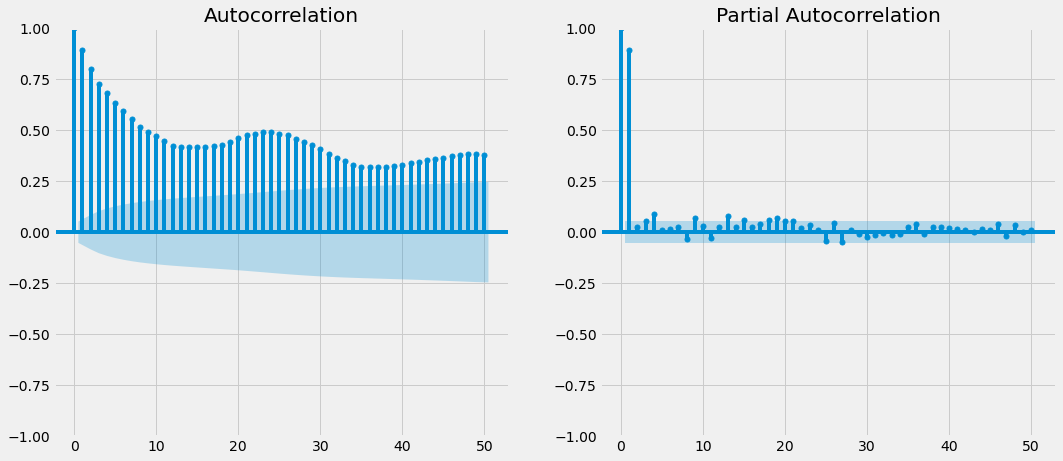

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 7))
plot_acf(df,lags=50, ax=ax1)
plot_pacf(df,lags=50, ax=ax2)
plt.show()

In [11]:
adf_result = adfuller(df)
print('ADF Statistic: %.3f' % adf_result[0])
print('p-value: %.3f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.749
p-value: 0.066
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


For this series, the p-value is very close to zero and much lower than the 3 confidence values mentioned. Therefore, we can reject the null hypothesis for this series. According to the ADF test, the time series of the concentration of particulate matter 2.5 in the air of Milan is therefore stationary.

## Create Model <a name="Create_Model"></a>

### Data Preparation

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[["y"]] = scaler.fit_transform(df[["y"]])

y_train, y_test =train_test_split(df,shuffle=False, test_size=0.3)

print(f'Train: {y_train.shape}')
print(f'Test: {y_test.shape}')

Train: (978, 1)
Test: (420, 1)


### Sampling

In [13]:
def sampling(sequence, n_steps):
    X, Y = list(), list()
    for i in range(len(sequence)):
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
            
        x, y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)

In [14]:
n_steps = 3
n_features = 1

X_train, Y_train = sampling(y_train["y"].tolist(), n_steps)
X_test, Y_test = sampling(y_test["y"].tolist(), n_steps)
    
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Model

In [15]:
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, Y_train,validation_data=(X_test, Y_test),epochs=8, batch_size=50,verbose=1)

Epoch 1/8
20/20 [==============================] - 1s 9ms/step - loss: 0.0401 - val_loss: 0.0994
Epoch 2/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0533
Epoch 3/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0325
Epoch 4/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0283
Epoch 5/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0224
Epoch 6/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0163
Epoch 7/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0124
Epoch 8/8
20/20 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0119


### Validation Model

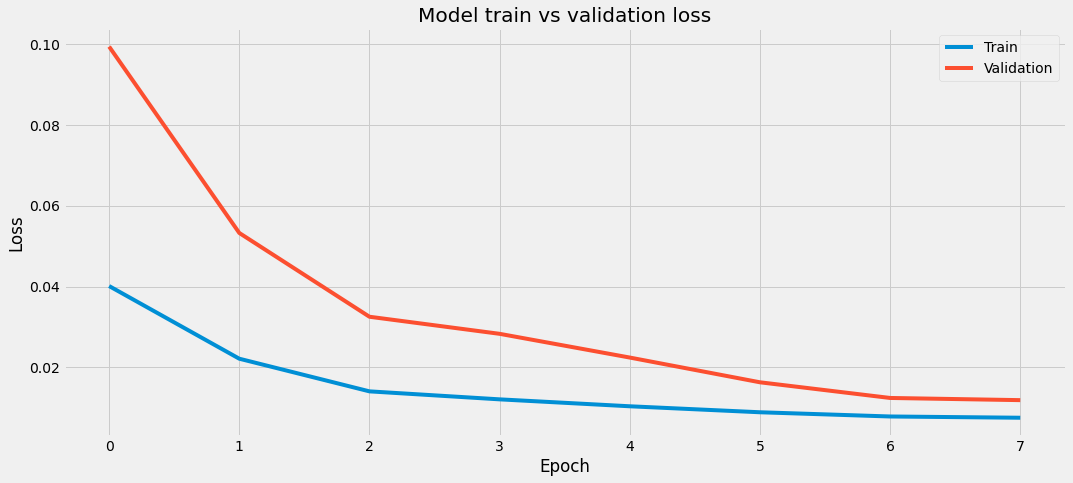

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model train vs validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])
plt.show()

In [18]:
y_train = y_train.iloc[n_steps:,:]
y_test = y_test.iloc[n_steps:,:]

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

y_train["pred_train"] = pd.Series(train_pred.flatten(), index=y_train.index)
y_test["pred_test"] = pd.Series(test_pred.flatten(), index=y_test.index)

In [19]:
train_score = mean_squared_error(y_train.y,y_train.pred_train)
print('Train Score: %.4f MSE' % (train_score))
print('Train Score: %.4f RMSE' % (np.sqrt(train_score)))

test_score = mean_squared_error(y_test.y,y_test.pred_test)
print('Test Score: %.4f MSE' % (test_score))
print('Test Score: %.4f RMSE' % (np.sqrt(test_score)))

Train Score: 0.0074 MSE
Train Score: 0.0860 RMSE
Test Score: 0.0119 MSE
Test Score: 0.1090 RMSE


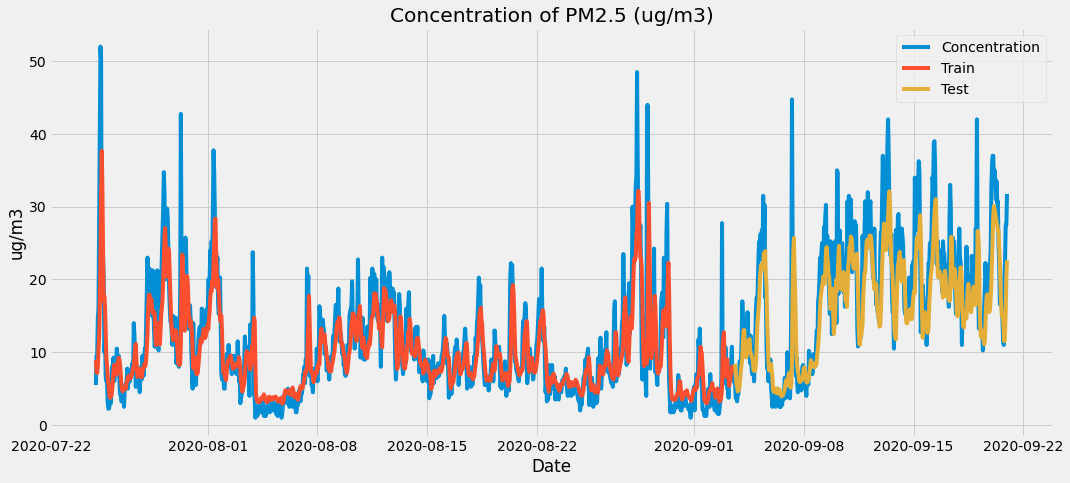

In [20]:
result= pd.concat([y_train,y_test])
result[["y","pred_train","pred_test"]] = scaler.inverse_transform(result[["y","pred_train","pred_test"]])

plt.plot(result.y,label="Concentration")
plt.plot(result.pred_train, label="Train")
plt.plot(result.pred_test, label="Test")
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()

The model looks good now let's make a forecast!

## Forecasting <a name="Forecasting"></a>

In [21]:
pred = model.predict(X_test[-24:])
index=pd.date_range(start="2020-09-20 23:00:00", periods=24, freq="H")
pred_df = pd.DataFrame(pred.flatten(), index=index, columns=["pred"])

result= pd.concat([result,pred_df])
result[["pred"]] = scaler.inverse_transform(result[["pred"]])

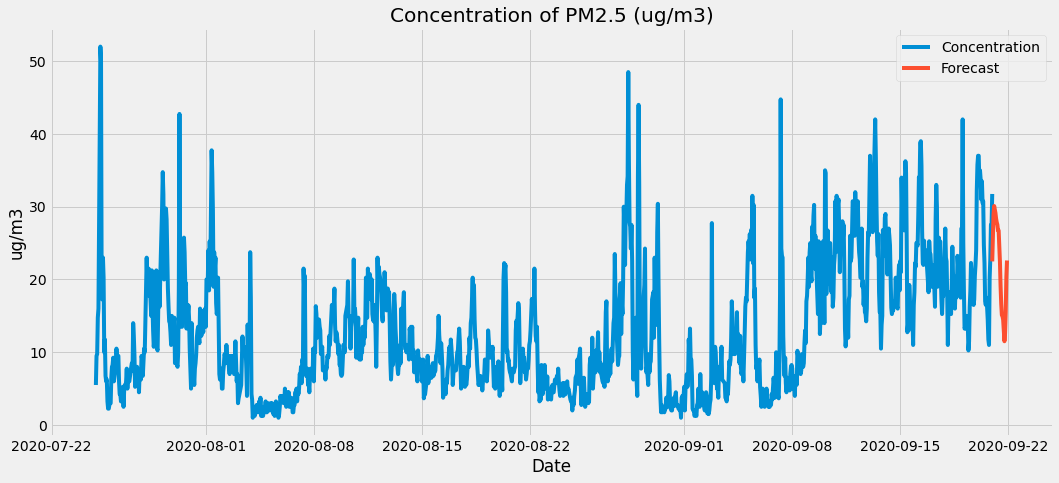

In [22]:
forecast = result[["y","pred"]]

plt.plot(forecast.y, label="Concentration")
plt.plot(forecast.pred ,label="Forecast")
plt.xlabel("Date")
plt.ylabel("ug/m3")
plt.legend()
plt.title("Concentration of PM2.5 (ug/m3)")
plt.show()